# Solving the 1d Heat equation with a PINN

And now...

It's time...

For the moment you've been waiting for

1...

2...

3...

Ready?

(Please *please* make the training loop output this when training starts)

In [85]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

In [169]:
# This is the head conductivity or whatever
R = 1e-4

## Data

In [170]:
class TemperatureDataset(Dataset):
    def __init__(self, initial_points, initial_temps, boundary_points, random_points):
        # Random points at t = 0
        self.initial_points = initial_points
        # Temperature at each initial point
        self.initial_temps = initial_temps
        # Random points at x boundary
        self.boundary_points = boundary_points
        # Random points in domain
        self.random_points = random_points

    def __len__(self):
        return len(self.random_points)
    
    def __getitem__(self, i):
        initial_point = self.initial_points[i]
        initial_temp = self.initial_temps[i]
        boundary_point = self.boundary_points[i]
        random_point = self.random_points[i]
        return initial_point, initial_temp, boundary_point, random_point

Train and test data

In [171]:
T_RANGE = 10
X_RANGE = 1
n_train_datapoints = 100_000

# Random points at t = 0
initial_points = torch.zeros((n_train_datapoints, 2))
initial_points[:, 1] = X_RANGE * torch.rand(n_train_datapoints)
# Temperature 1 if 1/4 <= x <= 3/4, else 0
initial_temps = torch.where(((initial_points[:, 1] >= 1/4) & (initial_points[:, 1] <= 3/4)), 1.0, 0.0)

# Random points at the x boundary
boundary_points = torch.zeros((n_train_datapoints, 2))
# Pick points at random times
boundary_points[:, 0] = T_RANGE * torch.rand(n_train_datapoints)
# Pick left or right boundary points randomly
boundary_points[:, 1] = X_RANGE * (torch.rand(n_train_datapoints)[:] >= 1/2).float()

# random points in (0, T_RANGE) x (0, X_RANGE)
random_points = torch.rand((n_train_datapoints, 2))
random_points[:, 0] *= T_RANGE
random_points[:, 1] *= X_RANGE

In [195]:
print(initial_points, initial_temps)
print(boundary_points)
print(random_points)

tensor([[0.0000, 0.7271],
        [0.0000, 0.2612],
        [0.0000, 0.7869],
        ...,
        [0.0000, 0.6496],
        [0.0000, 0.1648],
        [0.0000, 0.9314]]) tensor([1., 1., 0.,  ..., 1., 0., 0.])
tensor([[4.5172, 0.0000],
        [4.6372, 0.0000],
        [6.2763, 0.0000],
        ...,
        [6.0514, 1.0000],
        [7.2028, 1.0000],
        [1.4600, 0.0000]])
tensor([[8.1197, 0.8302],
        [4.0172, 0.5685],
        [7.4960, 0.9697],
        ...,
        [1.6962, 0.6566],
        [9.6492, 0.8760],
        [1.7105, 0.1491]])


Everything looks OK. Let's create the dataset and dataloader now.

In [173]:
batch_size = 128

In [174]:
train_dataset = TemperatureDataset(initial_points, initial_temps, boundary_points, random_points)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Yay it's working, now it's time to set things up and start training. First I need to figure out how to take partial derivatives.

## Model and differentiation

In [185]:
class TemperatureNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # inputs = t, x
            nn.Linear(2, 512),
            nn.Tanh(),
            nn.Linear(512,512),
            nn.Tanh(),
            nn.Linear(512,512),
            nn.Tanh(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [186]:
model = TemperatureNetwork()

This is how I'm supposed to do it in the training. Now I think I can start setting things up for training.

Model is working as expected!

## Training

In [196]:
learning_rate = 1e-4
weight_decay = 1e-4
n_epochs = 5

# Loss coefficients
A, B, C = 100, 1, 1

TRAIN = True

In [197]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [198]:
l1_loss = nn.SmoothL1Loss(reduction='mean')

def loss_fn(initial_temp_pred, initial_temp_target, boundary_temp_pred, dT_dt, d2T_dx2):
    initial_condition_loss = A * l1_loss(initial_temp_pred, initial_temp_target)
    boundary_condition_loss = B * l1_loss(boundary_temp_pred, torch.zeros_like(boundary_temp_pred))
    
    pde_difference = dT_dt - R * d2T_dx2
    pde_loss = C * l1_loss(pde_difference, torch.zeros_like(pde_difference))
    
    return initial_condition_loss + boundary_condition_loss + pde_loss

In [199]:
ip, it, bp, rp = next(iter(train_dataloader))
i_pred = model(ip)
b_pred = model(bp)
r_pred = model(rp)

loss = loss_fn(i_pred, it.unsqueeze(dim=1), b_pred, b_pred, b_pred)
print(loss)

tensor(11.1306, grad_fn=<AddBackward0>)


In [200]:
def train_loop(model, optimizer, loss_fn, dataloader, n_epochs):
    for epoch in range(n_epochs):
        print(f"epoch {epoch+1}-------------------")
        for i, (initial_points, initial_temps, boundary_points, random_points) in enumerate(dataloader):
            # Compute temperature at initial and boundary points
            initial_pred = model(initial_points)
            boundary_pred = model(boundary_points)

            # Compute temperature at random points
            random_points.requires_grad_(True)
            random_pred = model(random_points)

            # Compute dT/dt for each point in the batch
            dT_dt = torch.autograd.grad(random_pred, random_points, grad_outputs=torch.ones_like(random_pred), create_graph=True)[0][:, 0:1]
            
            # Compute d2T/dx2 for each point in the batch
            dT_dx = torch.autograd.grad(random_pred, random_points, grad_outputs=torch.ones_like(random_pred), create_graph=True)[0][:, 1:2]
            d2T_dx2 = torch.autograd.grad(dT_dx, random_points, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0][:, 1:2]

            # Compute loss and optimize
            loss = loss_fn(initial_pred, initial_temps, boundary_pred, dT_dt, d2T_dx2)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 100 == 0:
                with torch.no_grad():
                    print(f"train loss at batch {i}: {loss}")

In [201]:
if TRAIN:
    train_loop(model, optimizer, loss_fn, train_dataloader, n_epochs)

epoch 1-------------------
train loss at batch 0: 12.659355163574219
train loss at batch 100: 12.574355125427246
train loss at batch 200: 12.514609336853027
train loss at batch 300: 12.503425598144531
train loss at batch 400: 12.74774169921875
train loss at batch 500: 12.54696273803711
train loss at batch 600: 12.485265731811523
train loss at batch 700: 12.521921157836914
epoch 2-------------------
train loss at batch 0: 12.480514526367188
train loss at batch 100: 12.453530311584473
train loss at batch 200: 12.520675659179688
train loss at batch 300: 12.576621055603027
train loss at batch 400: 12.54016399383545
train loss at batch 500: 12.469595909118652
train loss at batch 600: 12.523956298828125
train loss at batch 700: 12.90242862701416
epoch 3-------------------
train loss at batch 0: 12.733986854553223
train loss at batch 100: 12.497902870178223
train loss at batch 200: 12.505764961242676
train loss at batch 300: 12.437417984008789
train loss at batch 400: 12.648906707763672
train

In [202]:
def display_model_output(model, t_range=(0, 10), x_range=(0, 1), resolution=100):
    model.eval()  # Set the model to evaluation mode
    
    # Create a grid of time and position values
    t = np.linspace(t_range[0], t_range[1], resolution)
    x = np.linspace(x_range[0], x_range[1], resolution)
    T, X = np.meshgrid(t, x)
    
    # Prepare input for the model
    points = np.vstack((T.flatten(), X.flatten())).T
    points_tensor = torch.FloatTensor(points)
    
    # Generate predictions
    with torch.no_grad():
        temp_pred = model(points_tensor).cpu().numpy()
    
    # Reshape the output for plotting
    temp_pred = temp_pred.reshape(resolution, resolution)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    im = plt.imshow(temp_pred, extent=[t_range[0], t_range[1], x_range[1], x_range[0]], 
                    aspect='auto', cmap='hot')
    plt.colorbar(im, label='Temperature')
    plt.title('Temperature Distribution over Time and Position')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()

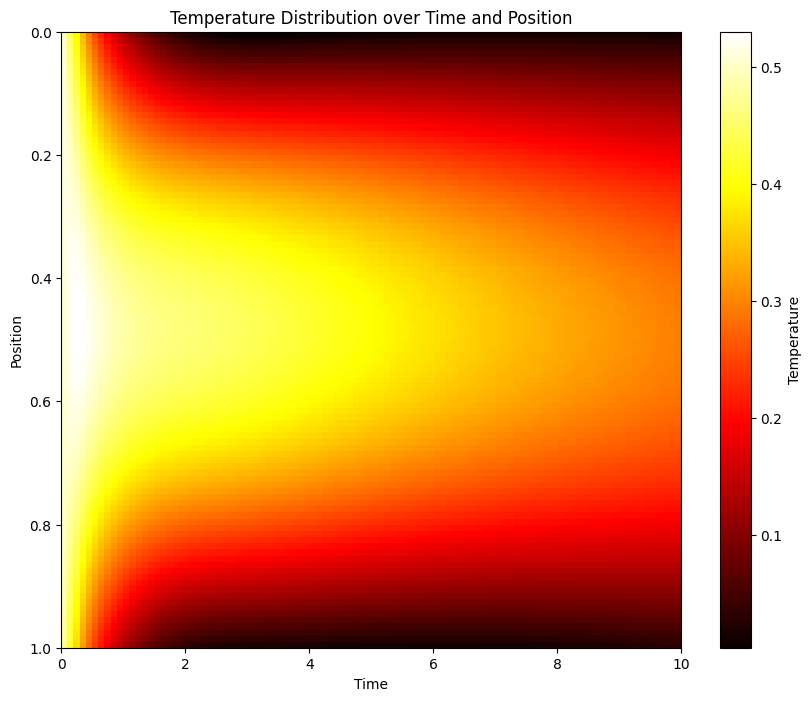

In [203]:
display_model_output(model)

Why is the initial condition converging to 0.5 everywhere??? I think that's the cause of the loss not going down.